# MNIST Autoencoder

In [1]:
# libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

## MNIST
Source: http://yann.lecun.com/exdb/mnist/  
Reading the data via tensorflow: https://www.tensorflow.org/get_started/mnist/beginners 

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

print("X_train: {} with shape {}, dtype {}, and values in range {}".format(type(X_train), X_train.shape, X_train.dtype,
                                                          (np.amin(X_train), np.amax(X_train))))
print("y_train: {} with shape {}, dtype {}, and values in range {}".format(type(y_train), y_train.shape, y_train.dtype,
                                                          (np.amin(y_train), np.amax(y_train))))
print("X_test: {} with shape {}, dtype {}, and values in range {}".format(type(X_test), X_test.shape, X_test.dtype,
                                                          (np.amin(X_test), np.amax(X_test))))
print("y_test: {} with shape {}, dtype {}, and values in range {}".format(type(y_test), y_test.shape, y_test.dtype,
                                                          (np.amin(y_test), np.amax(y_test))))

X_train: <class 'numpy.ndarray'> with shape (55000, 784), dtype float32, and values in range (0.0, 1.0)
y_train: <class 'numpy.ndarray'> with shape (55000, 10), dtype float64, and values in range (0.0, 1.0)
X_test: <class 'numpy.ndarray'> with shape (10000, 784), dtype float32, and values in range (0.0, 1.0)
y_test: <class 'numpy.ndarray'> with shape (10000, 10), dtype float64, and values in range (0.0, 1.0)


In [4]:
# function for plotting images
def plotImgs(X, n_examples, n_rows, figsize=(7,7), cmap=None):
    assert n_examples % n_rows == 0
    n_cols = n_examples/n_rows
    plt.figure(1, figsize=figsize)
    for i in range(n_examples):
        img = X[i]
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img, cmap=plt.get_cmap(cmap))
    plt.show()

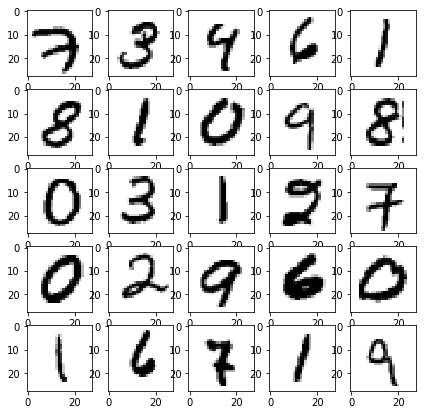

In [5]:
plotImgs(np.reshape(X_train, (X_train.shape[0],28,28)), 25, 5, cmap='gray_r')

## Autoencoder
References/Tutorials:
* https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/autoencoder.ipynb
* https://github.com/leriomaggio/deep-learning-keras-tensorflow/blob/master/6.%20AutoEncoders%20and%20Embeddings/6.1.%20AutoEncoders%20and%20Embeddings.ipynb
* https://github.com/BinRoot/TensorFlow-Book/blob/master/ch07_autoencoder/autoencoder.py
* https://github.com/tensorflow/models/tree/master/autoencoder

### Build graph

In [6]:
tf.reset_default_graph()

# hyperparameters
lr = 0.01
epochs = 20
batch_size = 256
n_batch = int(X_train.shape[0]/batch_size)  # floor
dtype = tf.float32
n_in = X_train.shape[1]
n_hidden = 32 #int(np.rint(n_in/2))
activate = tf.nn.sigmoid
optimizer = tf.train.AdamOptimizer
early_stop = 3

# variables to be trained
with tf.name_scope("weights"):
    weights = {
        'enc': tf.Variable(tf.random_normal([n_in, n_hidden]), dtype=dtype),
        'dec': tf.Variable(tf.random_normal([n_hidden, n_in]), dtype=dtype)
    }
with tf.name_scope("biases"):
    biases = {
        'enc': tf.Variable(tf.random_normal([n_hidden]), dtype=dtype),
        'dec': tf.Variable(tf.random_normal([n_in]), dtype=dtype)
    }

X = tf.placeholder(dtype, [None, n_in], "input")

with tf.name_scope("model"):    
    encoder = activate(tf.add(tf.matmul(X, weights['enc']), biases['enc']))
    decoder = activate(tf.add(tf.matmul(encoder, weights['dec']), biases['dec']))

with tf.name_scope("optimization"):
    cost = tf.reduce_mean(tf.square(tf.subtract(X, decoder)), name='cost')  # MSE
    optimization = optimizer(lr).minimize(cost)
    
# tf board
writer = tf.summary.FileWriter('mnist_logs', graph=tf.get_default_graph())
# saver for variables
saver = tf.train.Saver()

### Run graph

In [7]:
# get data in random batches
def getRandBatch(X, batch_size):
    # np.random.shuffle(X)
    start = np.random.randint(0, X.shape[0] - batch_size)
    return X[start:start+batch_size, :], start

In [8]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

# train model
history_cost = []
for e in range(epochs):
    
    X_temp = np.copy(X_train)
    for i in tqdm(range(n_batch)):
        batch, start = getRandBatch(X_temp, batch_size)
        # X_temp = np.delete(X_temp, np.s_[start:start+batch_size], axis=0)
        _, c = sess.run([optimization, cost], {X: batch})
    
    cost_overall = sess.run(cost, {X:X_train})
    history_cost.append(cost_overall)
    
    if e % 1 == 0:
        print("epoch {}\tcost {}".format(e, cost_overall))
        
    # early stopping in terms of cost
    if e >= early_stop:
        if (np.argmin(history_cost) == e - early_stop) and \
        (history_cost[e] - history_cost[e - early_stop] > 1e-5):
            print('early stop\nbest iteration: {}'.format(np.argmin(history_cost)))
            break
    
save_path = saver.save(tf.get_default_session(), "mnist_model/model.ckpt")
print("Model saved in file: {}".format(save_path))

  5%|▌         | 11/214 [00:00<00:01, 109.78it/s]

epoch 0	cost 0.05510539934039116


  0%|          | 0/214 [00:00<?, ?it/s]

epoch 1	cost 0.04737165942788124


  0%|          | 0/214 [00:00<?, ?it/s]

epoch 2	cost 0.042259130626916885


  0%|          | 0/214 [00:00<?, ?it/s]

epoch 3	cost 0.03914117068052292


  0%|          | 0/214 [00:00<?, ?it/s]

epoch 4	cost 0.03649893403053284


  0%|          | 0/214 [00:00<?, ?it/s]

epoch 5	cost 0.03209943696856499


  0%|          | 0/214 [00:00<?, ?it/s]

epoch 6	cost 0.029963430017232895


  0%|          | 0/214 [00:00<?, ?it/s]

epoch 7	cost 0.028789952397346497


  6%|▌         | 12/214 [00:00<00:01, 116.47it/s]

epoch 8	cost 0.027904298156499863


  6%|▌         | 12/214 [00:00<00:01, 119.35it/s]

epoch 9	cost 0.026748891919851303


  0%|          | 0/214 [00:00<?, ?it/s]

epoch 10	cost 0.02598203904926777


  6%|▌         | 12/214 [00:00<00:01, 117.52it/s]

epoch 11	cost 0.024291353300213814


  0%|          | 0/214 [00:00<?, ?it/s]

epoch 12	cost 0.024074437096714973


  6%|▌         | 12/214 [00:00<00:01, 119.51it/s]

epoch 13	cost 0.023407110944390297


  6%|▌         | 12/214 [00:00<00:01, 116.66it/s]

epoch 14	cost 0.0227980799973011


  0%|          | 0/214 [00:00<?, ?it/s]

epoch 15	cost 0.02226966619491577


  5%|▌         | 11/214 [00:00<00:01, 109.21it/s]

epoch 16	cost 0.022023947909474373


  0%|          | 0/214 [00:00<?, ?it/s]

epoch 17	cost 0.021721066907048225


  0%|          | 0/214 [00:00<?, ?it/s]

epoch 18	cost 0.02162773348391056


100%|██████████| 214/214 [00:01<00:00, 144.13it/s]


epoch 19	cost 0.021485257893800735
Model saved in file: mnist_model/model.ckpt


## Plot results

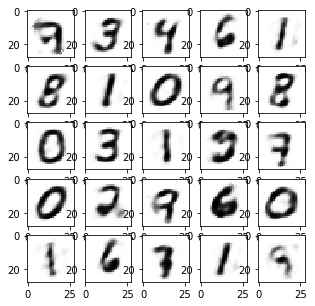

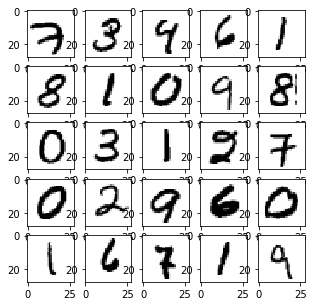

In [9]:
# test model on its input (training data)
pred_train = sess.run(decoder, feed_dict={X: X_train})
# compare
plotImgs(np.reshape(pred_train, (pred_train.shape[0],28,28)), 25, 5, figsize=(5,5), cmap='gray_r')
plotImgs(np.reshape(X_train, (X_train.shape[0],28,28)), 25, 5, figsize=(5,5), cmap='gray_r')

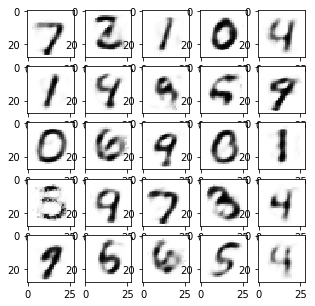

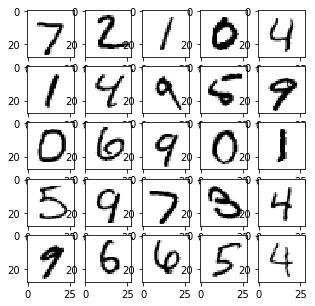

In [10]:
# test model on test data
pred_test = sess.run(decoder, feed_dict={X: X_test})
# compare
plotImgs(np.reshape(pred_test, (pred_test.shape[0],28,28)), 25, 5, figsize=(5,5), cmap='gray_r')
plotImgs(np.reshape(X_test, (X_test.shape[0],28,28)), 25, 5, figsize=(5,5), cmap='gray_r')